# **Deep Learning Project - Roman, Bonetto, Dian**

---





## **Table of contents**

* Introduction

* Marginal Entropy Minimization with One test point (MEMO)

* Methodology
  
  - Model description - From Resnet50 to VitB16
  - Dataset - Imagenet-A
  - Loss function
  - GradCAM
  - Augmentations
  - Our MEMO_PLUS version

* Experiments and results
  - Experiment 1: ResNET-50 vs ViTB-16
    - Experiment 1.1: Vanilla ResNET-50
      - 1.1 Results
    - Experiment 1.2: Vanilla ViTB-16       
      - 1.2 Results
    - Conclusions and comparison
  - Experiment 2: implementing MEMO
    - 2 Results
  - Experiment 3: MEMO_PLUS, our improvements
    - 3 Results

* Conclusions

## **Introduction**

Deep neural networks (DNNs) often encounter significant performance degradation when subjected to images that differ substantially from those seen during training. This issue, known as **domain shift**, poses a critical challenge in deploying DNNs across diverse and unseen environments. For instance, when we evaluate a ResNet-50 model pre-trained on the ImageNet-1k dataset on ImageNet-A, which consists of challenging and naturally occurring adversarial images, the **model's accuracy drops markedly**. This stark performance drop underscores the model's limited robustness to domain shifts and highlights the need for methods that can effectively adapt to new and diverse datasets.

To tackle this issue, a solution is using **Test Time Adaptation (TTA)** that improves the robustness of a pre-trained neural network to a test dataset, possibly by improving the network's predictions on test samples.

Our project is centered on researching and developing techniques to enhance the performance of **Marginal Entropy Minimization with One test point (MEMO)**. This is a TTA method, enabling the model to adapt and function effectively without requiring labels, making the testing process more efficient and flexible.

Our final goal is to refine MEMO to better handle such discrepancies, ensuring robust and accurate model performance across diverse and unseen datasets. In particular we focused on better enhancing augmentations' effectivity, involving the use of segmentations and GradCam to help the model to focus on the most informative parts of the images.

## **Marginal Entropy Minimization with One test point (MEMO)**

[MEMO](https://arxiv.org/abs/2110.09506) focuses on adapting a pre-trained model to a specific test sample $x \in X$. The process begins by applying a set of augmentations $\{a_1,…,a_M\}$ to the input sample. These transformations help the model to better understand variations in the data.

Once the augmented versions of the sample are created, MEMO calculates the average output distribution $p(y∣x;w)$ by combining the predictions from each augmented view. The goal is to minimize the entropy of this marginal distribution, which helps ensure that the model produces consistent predictions across different augmentations.

The final prediction for the sample is made by selecting the class $\hat{y}$ that has the highest probability, as represented by the equation:

$$
  \hat{y} = M(x|w) = argmax_{y \in Y} p(y| x; w)
$$

Overall, MEMO aims to enhance the performance of the model on the test dataset by ensuring that it generates reliable predictions, **even in the absence of known labels**. This is achieved by promoting consistency in the model's outputs across various transformed versions of the test sample.


<center>

<img src="https://raw.github.com/stefanoobonetto/DeepLearning_project/31b5631b3b89397a0110ab70261f1a044ace4784/imagesReport/memo_scheme.png" alt="MEMO" width="800"/>

</center>

## **Methodology**

### **Model description - From Resnet50 to VitB16**

Our project initially used the [ResNet-50](https://pytorch.org/vision/main/models/generated/torchvision.models.resnet50.html) architecture as its backbone, owing to its capacity to capture hierarchical features through its convolutional layers and residual connections.

> *CNNs, such as ResNet-50, struggle to capture global context and long-range dependencies effectively. This is because they rely on local convolutional filters that process information in a fragmentary, hierarchical manner. As a result, ResNet-50 is less effective compared to the other models we will discuss below.*


<center>

<img src="https://raw.github.com/stefanoobonetto/DeepLearning_project/31b5631b3b89397a0110ab70261f1a044ace4784/imagesReport/resnet.png" alt="MEMO" width="700"/>

</center>

<br>
<hr>
<br>

In contrast, **Vision Transformers (ViTs)** like the [ViT-B/16](https://pytorch.org/vision/main/models/generated/torchvision.models.vit_b_16.html), which we subsequently adopted, offer a more holistic approach to image analysis.

> *ViTB-16 processes images by **dividing them into fixed-size patches**, treating each patch as a token in a sequence. Unlike CNNs, where each convolutional filter only interacts with a local neighborhood, the Vision Transformer employs self-attention mechanisms to capture relationships between distant patches across the entire image simultaneously. This enables the model for example, to establish connections between a patch in the top-left corner and one in the bottom-right corner in a single pass, effectively capturing global context and spatial relationships.*

<p align="center">
  <img src="https://miro.medium.com/v2/resize:fit:1400/1*l37va2Mu8Snx6LLb13430A.png" alt="ViT architecture" width="600" />
</p>

<br>

We decided to switch to ViTB-16 knowing his superior ability to **model long-range dependencies and global interactions directly**, which proved crucial in addressing the domain shift challenges we encountered. The Vision Transformer's capacity to understand complex spatial relationships and adapt to various data distributions was confirmed through our evaluations on challenging ImageNet-A, where it demonstrated significant improvements in robustness and accuracy over the initial ResNet-50 baseline.

<br>

We start by importing all the libraries:

In [ ]:
import os
import cv2
import tqdm
import torch
import random
import torchvision
import numpy as np
import torch.nn as nn
from torch import optim
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter
import torchvision.transforms as T
from scipy.ndimage import gaussian_filter, map_coordinates

We use this mapping to extract the indices of the 200 classes of Imagenet-A from the 1000 of Imagenet-1K:

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

thousand_k_to_200 = {0: -1, 1: -1, 2: -1, 3: -1, 4: -1, 5: -1, 6: 0, 7: -1, 8: -1, 9: -1, 10: -1, 11: 1, 12: -1, 13: 2, 14: -1, 15: 3, 16: -1, 17: 4, 18: -1, 19: -1, 20: -1, 21: -1, 22: 5, 23: 6, 24: -1, 25: -1, 26: -1, 27: 7, 28: -1, 29: -1, 30: 8, 31: -1, 32: -1, 33: -1, 34: -1, 35: -1, 36: -1, 37: 9, 38: -1, 39: 10, 40: -1, 41: -1, 42: 11, 43: -1, 44: -1, 45: -1, 46: -1, 47: 12, 48: -1, 49: -1, 50: 13, 51: -1, 52: -1, 53: -1, 54: -1, 55: -1, 56: -1, 57: 14, 58: -1, 59: -1, 60: -1, 61: -1, 62: -1, 63: -1, 64: -1, 65: -1, 66: -1, 67: -1, 68: -1, 69: -1, 70: 15, 71: 16, 72: -1, 73: -1, 74: -1, 75: -1, 76: 17, 77: -1, 78: -1, 79: 18, 80: -1, 81: -1, 82: -1, 83: -1, 84: -1, 85: -1, 86: -1, 87: -1, 88: -1, 89: 19, 90: 20, 91: -1, 92: -1, 93: -1, 94: 21, 95: -1, 96: 22, 97: 23, 98: -1, 99: 24, 100: -1, 101: -1, 102: -1, 103: -1, 104: -1, 105: 25, 106: -1, 107: 26, 108: 27, 109: -1, 110: 28, 111: -1, 112: -1, 113: 29, 114: -1, 115: -1, 116: -1, 117: -1, 118: -1, 119: -1, 120: -1, 121: -1, 122: -1, 123: -1, 124: 30, 125: 31, 126: -1, 127: -1, 128: -1, 129: -1, 130: 32, 131: -1, 132: 33, 133: -1, 134: -1, 135: -1, 136: -1, 137: -1, 138: -1, 139: -1, 140: -1, 141: -1, 142: -1, 143: 34, 144: 35, 145: -1, 146: -1, 147: -1, 148: -1, 149: -1, 150: 36, 151: 37, 152: -1, 153: -1, 154: -1, 155: -1, 156: -1, 157: -1, 158: -1, 159: -1, 160: -1, 161: -1, 162: -1, 163: -1, 164: -1, 165: -1, 166: -1, 167: -1, 168: -1, 169: -1, 170: -1, 171: -1, 172: -1, 173: -1, 174: -1, 175: -1, 176: -1, 177: -1, 178: -1, 179: -1, 180: -1, 181: -1, 182: -1, 183: -1, 184: -1, 185: -1, 186: -1, 187: -1, 188: -1, 189: -1, 190: -1, 191: -1, 192: -1, 193: -1, 194: -1, 195: -1, 196: -1, 197: -1, 198: -1, 199: -1, 200: -1, 201: -1, 202: -1, 203: -1, 204: -1, 205: -1, 206: -1, 207: 38, 208: -1, 209: -1, 210: -1, 211: -1, 212: -1, 213: -1, 214: -1, 215: -1, 216: -1, 217: -1, 218: -1, 219: -1, 220: -1, 221: -1, 222: -1, 223: -1, 224: -1, 225: -1, 226: -1, 227: -1, 228: -1, 229: -1, 230: -1, 231: -1, 232: -1, 233: -1, 234: 39, 235: 40, 236: -1, 237: -1, 238: -1, 239: -1, 240: -1, 241: -1, 242: -1, 243: -1, 244: -1, 245: -1, 246: -1, 247: -1, 248: -1, 249: -1, 250: -1, 251: -1, 252: -1, 253: -1, 254: 41, 255: -1, 256: -1, 257: -1, 258: -1, 259: -1, 260: -1, 261: -1, 262: -1, 263: -1, 264: -1, 265: -1, 266: -1, 267: -1, 268: -1, 269: -1, 270: -1, 271: -1, 272: -1, 273: -1, 274: -1, 275: -1, 276: -1, 277: 42, 278: -1, 279: -1, 280: -1, 281: -1, 282: -1, 283: 43, 284: -1, 285: -1, 286: -1, 287: 44, 288: -1, 289: -1, 290: -1, 291: 45, 292: -1, 293: -1, 294: -1, 295: 46, 296: -1, 297: -1, 298: 47, 299: -1, 300: -1, 301: 48, 302: -1, 303: -1, 304: -1, 305: -1, 306: 49, 307: 50, 308: 51, 309: 52, 310: 53, 311: 54, 312: -1, 313: 55, 314: 56, 315: 57, 316: -1, 317: 58, 318: -1, 319: 59, 320: -1, 321: -1, 322: -1, 323: 60, 324: 61, 325: -1, 326: 62, 327: 63, 328: -1, 329: -1, 330: 64, 331: -1, 332: -1, 333: -1, 334: 65, 335: 66, 336: 67, 337: -1, 338: -1, 339: -1, 340: -1, 341: -1, 342: -1, 343: -1, 344: -1, 345: -1, 346: -1, 347: 68, 348: -1, 349: -1, 350: -1, 351: -1, 352: -1, 353: -1, 354: -1, 355: -1, 356: -1, 357: -1, 358: -1, 359: -1, 360: -1, 361: 69, 362: -1, 363: 70, 364: -1, 365: -1, 366: -1, 367: -1, 368: -1, 369: -1, 370: -1, 371: -1, 372: 71, 373: -1, 374: -1, 375: -1, 376: -1, 377: -1, 378: 72, 379: -1, 380: -1, 381: -1, 382: -1, 383: -1, 384: -1, 385: -1, 386: 73, 387: -1, 388: -1, 389: -1, 390: -1, 391: -1, 392: -1, 393: -1, 394: -1, 395: -1, 396: -1, 397: 74, 398: -1, 399: -1, 400: 75, 401: 76, 402: 77, 403: -1, 404: 78, 405: -1, 406: -1, 407: 79, 408: -1, 409: -1, 410: -1, 411: 80, 412: -1, 413: -1, 414: -1, 415: -1, 416: 81, 417: 82, 418: -1, 419: -1, 420: 83, 421: -1, 422: -1, 423: -1, 424: -1, 425: 84, 426: -1, 427: -1, 428: 85, 429: -1, 430: 86, 431: -1, 432: -1, 433: -1, 434: -1, 435: -1, 436: -1, 437: 87, 438: 88, 439: -1, 440: -1, 441: -1, 442: -1, 443: -1, 444: -1, 445: 89, 446: -1, 447: -1, 448: -1, 449: -1, 450: -1, 451: -1, 452: -1, 453: -1, 454: -1, 455: -1, 456: 90, 457: 91, 458: -1, 459: -1, 460: -1, 461: 92, 462: 93, 463: -1, 464: -1, 465: -1, 466: -1, 467: -1, 468: -1, 469: -1, 470: 94, 471: -1, 472: 95, 473: -1, 474: -1, 475: -1, 476: -1, 477: -1, 478: -1, 479: -1, 480: -1, 481: -1, 482: -1, 483: 96, 484: -1, 485: -1, 486: 97, 487: -1, 488: 98, 489: -1, 490: -1, 491: -1, 492: 99, 493: -1, 494: -1, 495: -1, 496: 100, 497: -1, 498: -1, 499: -1, 500: -1, 501: -1, 502: -1, 503: -1, 504: -1, 505: -1, 506: -1, 507: -1, 508: -1, 509: -1, 510: -1, 511: -1, 512: -1, 513: -1, 514: 101, 515: -1, 516: 102, 517: -1, 518: -1, 519: -1, 520: -1, 521: -1, 522: -1, 523: -1, 524: -1, 525: -1, 526: -1, 527: -1, 528: 103, 529: -1, 530: 104, 531: -1, 532: -1, 533: -1, 534: -1, 535: -1, 536: -1, 537: -1, 538: -1, 539: 105, 540: -1, 541: -1, 542: 106, 543: 107, 544: -1, 545: -1, 546: -1, 547: -1, 548: -1, 549: 108, 550: -1, 551: -1, 552: 109, 553: -1, 554: -1, 555: -1, 556: -1, 557: 110, 558: -1, 559: -1, 560: -1, 561: 111, 562: 112, 563: -1, 564: -1, 565: -1, 566: -1, 567: -1, 568: -1, 569: 113, 570: -1, 571: -1, 572: 114, 573: 115, 574: -1, 575: 116, 576: -1, 577: -1, 578: -1, 579: 117, 580: -1, 581: -1, 582: -1, 583: -1, 584: -1, 585: -1, 586: -1, 587: -1, 588: -1, 589: 118, 590: -1, 591: -1, 592: -1, 593: -1, 594: -1, 595: -1, 596: -1, 597: -1, 598: -1, 599: -1, 600: -1, 601: -1, 602: -1, 603: -1, 604: -1, 605: -1, 606: 119, 607: 120, 608: -1, 609: 121, 610: -1, 611: -1, 612: -1, 613: -1, 614: 122, 615: -1, 616: -1, 617: -1, 618: -1, 619: -1, 620: -1, 621: -1, 622: -1, 623: -1, 624: -1, 625: -1, 626: 123, 627: 124, 628: -1, 629: -1, 630: -1, 631: -1, 632: -1, 633: -1, 634: -1, 635: -1, 636: -1, 637: -1, 638: -1, 639: -1, 640: 125, 641: 126, 642: 127, 643: 128, 644: -1, 645: -1, 646: -1, 647: -1, 648: -1, 649: -1, 650: -1, 651: -1, 652: -1, 653: -1, 654: -1, 655: -1, 656: -1, 657: -1, 658: 129, 659: -1, 660: -1, 661: -1, 662: -1, 663: -1, 664: -1, 665: -1, 666: -1, 667: -1, 668: 130, 669: -1, 670: -1, 671: -1, 672: -1, 673: -1, 674: -1, 675: -1, 676: -1, 677: 131, 678: -1, 679: -1, 680: -1, 681: -1, 682: 132, 683: -1, 684: 133, 685: -1, 686: -1, 687: 134, 688: -1, 689: -1, 690: -1, 691: -1, 692: -1, 693: -1, 694: -1, 695: -1, 696: -1, 697: -1, 698: -1, 699: -1, 700: -1, 701: 135, 702: -1, 703: -1, 704: 136, 705: -1, 706: -1, 707: -1, 708: -1, 709: -1, 710: -1, 711: -1, 712: -1, 713: -1, 714: -1, 715: -1, 716: -1, 717: -1, 718: -1, 719: 137, 720: -1, 721: -1, 722: -1, 723: -1, 724: -1, 725: -1, 726: -1, 727: -1, 728: -1, 729: -1, 730: -1, 731: -1, 732: -1, 733: -1, 734: -1, 735: -1, 736: 138, 737: -1, 738: -1, 739: -1, 740: -1, 741: -1, 742: -1, 743: -1, 744: -1, 745: -1, 746: 139, 747: -1, 748: -1, 749: 140, 750: -1, 751: -1, 752: 141, 753: -1, 754: -1, 755: -1, 756: -1, 757: -1, 758: 142, 759: -1, 760: -1, 761: -1, 762: -1, 763: 143, 764: -1, 765: 144, 766: -1, 767: -1, 768: 145, 769: -1, 770: -1, 771: -1, 772: -1, 773: 146, 774: 147, 775: -1, 776: 148, 777: -1, 778: -1, 779: 149, 780: 150, 781: -1, 782: -1, 783: -1, 784: -1, 785: -1, 786: 151, 787: -1, 788: -1, 789: -1, 790: -1, 791: -1, 792: 152, 793: -1, 794: -1, 795: -1, 796: -1, 797: 153, 798: -1, 799: -1, 800: -1, 801: -1, 802: 154, 803: 155, 804: 156, 805: -1, 806: -1, 807: -1, 808: -1, 809: -1, 810: -1, 811: -1, 812: -1, 813: 157, 814: -1, 815: 158, 816: -1, 817: -1, 818: -1, 819: -1, 820: 159, 821: -1, 822: -1, 823: 160, 824: -1, 825: -1, 826: -1, 827: -1, 828: -1, 829: -1, 830: -1, 831: 161, 832: -1, 833: 162, 834: -1, 835: 163, 836: -1, 837: -1, 838: -1, 839: 164, 840: -1, 841: -1, 842: -1, 843: -1, 844: -1, 845: 165, 846: -1, 847: 166, 848: -1, 849: -1, 850: 167, 851: -1, 852: -1, 853: -1, 854: -1, 855: -1, 856: -1, 857: -1, 858: -1, 859: 168, 860: -1, 861: -1, 862: 169, 863: -1, 864: -1, 865: -1, 866: -1, 867: -1, 868: -1, 869: -1, 870: 170, 871: -1, 872: -1, 873: -1, 874: -1, 875: -1, 876: -1, 877: -1, 878: -1, 879: 171, 880: 172, 881: -1, 882: -1, 883: -1, 884: -1, 885: -1, 886: -1, 887: -1, 888: 173, 889: -1, 890: 174, 891: -1, 892: -1, 893: -1, 894: -1, 895: -1, 896: -1, 897: 175, 898: -1, 899: -1, 900: 176, 901: -1, 902: -1, 903: -1, 904: -1, 905: -1, 906: -1, 907: 177, 908: -1, 909: -1, 910: -1, 911: -1, 912: -1, 913: 178, 914: -1, 915: -1, 916: -1, 917: -1, 918: -1, 919: -1, 920: -1, 921: -1, 922: -1, 923: -1, 924: 179, 925: -1, 926: -1, 927: -1, 928: -1, 929: -1, 930: -1, 931: -1, 932: 180, 933: 181, 934: 182, 935: -1, 936: -1, 937: 183, 938: -1, 939: -1, 940: -1, 941: -1, 942: -1, 943: 184, 944: -1, 945: 185, 946: -1, 947: 186, 948: -1, 949: -1, 950: -1, 951: 187, 952: -1, 953: -1, 954: 188, 955: -1, 956: 189, 957: 190, 958: -1, 959: 191, 960: -1, 961: -1, 962: -1, 963: -1, 964: -1, 965: -1, 966: -1, 967: -1, 968: -1, 969: -1, 970: -1, 971: 192, 972: 193, 973: -1, 974: -1, 975: -1, 976: -1, 977: -1, 978: -1, 979: -1, 980: 194, 981: 195, 982: -1, 983: -1, 984: 196, 985: -1, 986: 197, 987: 198, 988: 199, 989: -1, 990: -1, 991: -1, 992: -1, 993: -1, 994: -1, 995: -1, 996: -1, 997: -1, 998: -1, 999: -1}
indices_in_1k = [k for k in thousand_k_to_200 if thousand_k_to_200[k] != -1]

Then we define our ViTB-16 model (we define also the ResNet50 model to use it as comparison) we use the default weights (for ResNet-50, the default weights are set to IMAGENET1K_V2_Weights, whereas for ViT-B/16, the default weights are set to IMAGENET1K_V1_Weights.):


In [ ]:
from torchvision.models import resnet50, ResNet50_Weights, vit_b_16, ViT_B_16_Weights

class ModelResNet(nn.Module):

    def __init__(self):
        super(ModelResNet, self).__init__()

        self.resnet50 = resnet50(weights=ResNet50_Weights.DEFAULT)

    def forward(self, input):

        output = self.resnet50(input)

        return output

class ModelVitb16(nn.Module):

    def __init__(self):
        super(ModelVitb16, self).__init__()

        self.vitb = vit_b_16(weights=ViT_B_16_Weights.DEFAULT)

    def forward(self, input):

        output = self.vitb(input)

        return output

### **Dataset - Imagenet-A**

As we mentioned earlier, we're using a pre-trained Vision Transformer (ViT), specifically ViTB-16. Our main goal is to ensure it **performs well on ImageNet-A** which is known for its tough and diverse images that differ significantly from those in standard ImageNet datasets.

ImageNet-A consists of **7500 images** spread across **200 classes**. Each image is carefully chosen to challenge models with complex visual variations and anomalies. This dataset is quite different from the original ImageNet-1k, which has **1000 classes** and is commonly used for standard image classification tasks.

Our aim is to fine-tune ViT-B adapting his learned features to better understand and classify the kinds of images found in ImageNet-A.

<br>

We start by downloading and extracting the Imagenet-A dataset:

In [ ]:
!wget https://people.eecs.berkeley.edu/~hendrycks/imagenet-a.tar
!mkdir -p datasets
!tar -xf imagenet-a.tar -C datasets
!sudo rm -r imagenet-a.tar

current_dir = os.getcwd()
pathDatasetImagenetA = os.path.join(current_dir, "datasets/imagenet-a")

--2024-07-18 16:30:17--  https://people.eecs.berkeley.edu/~hendrycks/imagenet-a.tar
Resolving people.eecs.berkeley.edu (people.eecs.berkeley.edu)... 128.32.244.190
Connecting to people.eecs.berkeley.edu (people.eecs.berkeley.edu)|128.32.244.190|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 687552512 (656M) [application/x-tar]
Saving to: ‘imagenet-a.tar’

imagenet-a.tar      100%[===================>] 655.70M  15.6MB/s    in 43s     

2024-07-18 16:31:01 (15.1 MB/s) - ‘imagenet-a.tar’ saved [687552512/687552512]



We define a function that instantiate our data loader to preprocess the data:


> *We implemented a function called ```get_WholeDataset``` to test it on the entire dataset. However, we also implemented the function ```get_SubDataset``` which, using a random seed, returns a subdataset of N_IMAGES images. This allowed us to test the model on a sufficient number of images to obtain a reliable estimate of the model's performance.*

> *With ```transform``` we prepare the images ensuring that they're of the correct size required by the models and correctly normalized according to Imagenet mean and standard deviation.*

In [ ]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Prepare data transformations
transform = T.Compose([
    T.Resize((224, 224)),                                                   # Resize each PIL image to 224 x 224
    T.ToTensor(),                                                           # Convert Numpy to Pytorch Tensor
    T.Normalize(mean, std)                                                  # Normalize with ImageNet mean
])

# This returns the whole dataset
def get_WholeDataset(batch_size, img_root, num_workers=2):
    # Load data
    imagenet_dataset = torchvision.datasets.ImageFolder(root=img_root)

    return imagenet_dataset

# This returns a subset of the dataset according to random_seed value and subset_size
def get_SubDataset(batch_size, img_root, subset_size, random_seed, num_workers=2):

    # Set the random seed for reproducibility
    torch.manual_seed(random_seed)
    np.random.seed(random_seed)

    # Full dataset
    imagenet_dataset = torchvision.datasets.ImageFolder(root=img_root)

    indices = np.random.choice(len(imagenet_dataset), size=subset_size, replace=False)
    imagenet_subset = torch.utils.data.Subset(imagenet_dataset, indices)

    return imagenet_subset

## **Loss function**

As we've seen, MEMO is based on marginal entropy minimization that involves generating multiple augmented versions of a test point and analyzing the model's output distribution across these variations.

The goal is to make the model's predictions both invariant (consistent across different augmentations) and confident, even for heavily modified versions of the test point. To achieve this, we compute the entropy for each sample $x$:

$$
  \mathcal{l}(\theta; x) \triangleq \frac{1}{B} \sum_{i=1}^B H(p_{\theta}(\cdot | \tilde{x_i}))
$$

The model is adapted using the entropy of its average output distribution over $B$ augmentations, with the aim of minimizing this entropy to ensure uniform and confident predictions:

$$
  \bar{p_{\theta}}(y|x) = \mathbf{E}_{U(A)} [p_{\theta}(y|a(x))] \approx \frac{1}{B} \sum_{i=1}^{B} p_{\theta}(y|\tilde{x_i})
$$

This computes the expected probability of each class $y$ given input $x$, averaging predictions across $B$ perturbed samples $\tilde{x_i}$ (augmentated version of the sample $x_i$).

Marginal entropy is ideal for MEMO because it **minimizes prediction uncertainty across varied inputs $\mathbf{x}$**. By averaging predictions over perturbed samples, it enhances model stability and performance on diverse datasets like ImageNet-A.


In [ ]:
def marginal_entropy(outputs):
    log_probs = outputs - outputs.logsumexp(dim=-1, keepdim=True)
    avg_log_probs = log_probs.logsumexp(dim=0) - np.log(log_probs.shape[0])

    min_real = torch.finfo(avg_log_probs.dtype).min
    avg_log_probs = torch.clamp(avg_log_probs, min=min_real)

    entropy = -(avg_log_probs * torch.exp(avg_log_probs)).sum(dim=-1)
    return entropy, avg_log_probs

## **Grad-CAM**

[Grad-CAM](https://arxiv.org/abs/1610.02391) (Gradient-weighted Class Activation Mapping) is a widely used technique in explainable AI to visualize important regions of an image for model predictions. In many applications, including ours, it helps to enhance model performance by focusing on the most descriptive regions of the image.

It produces a heat map that highlights important regions of an image using the target gradients of the final convolutional layer.

It is class-specific, meaning that it can produce a separate visualisation for each class present in the image.

To compute the Grad-CAM heatmap, we need to obtain the activations and gradients from the target layer. This involves performing two "dummy" steps:

* **Forward Pass**: In this step, we capture the activations from the target layer and the output label that we'll use in the backward pass (for this reason, if the prediction is hardly wrong, GradCAM is consequentially wrong). These activations represent the features extracted from the input image at each spatial location.

* **Backward Pass**: Without updating the model weights, we perform a backward pass to obtain the gradients of the target class with respect to the activations. These gradients indicate the importance of each feature in the decision-making process.

The activations provide the spatial information about the features, while the gradients highlight their relevance for the classification task. To obtain that we use a sort of listener (the ```hook```) that triggers whenever both the forward and the backward step is run. Gradients and activations together, help generate a heatmap that visualizes the regions of the image that are most important for the model's prediction.

The final step is generating the **localization map**:

* Perform global average pooling on the gradients to obtain weights for each feature map.
* Compute a weighted sum of the feature maps using these weights.
* Apply a ReLU activation to the weighted sum to focus on the positive influences.
* The resulting heatmap is upsampled to match the input image dimensions, producing the Grad-CAM localization map.

In our application we use GradCam mainly for two purposes:

- We use the higher interest point resulted from the heatmap to enhance augmentations (aiming crop and nearest segmentations, see at MEMO_PLUS section).
- To debug our model to understand if his prediction are based on very discriminative features or simply artifacts.


<center>

<img src="https://raw.githubusercontent.com/stefanoobonetto/DeepLearning_project/2c1ba1224854a2b7e9cbb65463eade580eb6c57b/imagesReport/gradcam_memo.png" alt="MEMO" width="600"/>

</center>

<br>

These are some examples of GradCAM heatmaps, in particular we compared our MEMO_PLUS version with the ones produced using ViTB-16 and MEMO inference.

<br>

<center>

| Original Image      | VitB-16 Vanilla   | MEMO Vanilla      | Our MEMO_PLUS   |
|------------|---------------|------------|---------------|
| ![Original](https://raw.github.com/stefanoobonetto/DeepLearning_project/0f0e6e9922f38f99f6631765e90cf3a6fdcda2a1/imagesReport/original_image.png) |![](https://raw.github.com/stefanoobonetto/DeepLearning_project/0f0e6e9922f38f99f6631765e90cf3a6fdcda2a1/imagesReport/gradcam_original.png) | ![](https://raw.github.com/stefanoobonetto/DeepLearning_project/0f0e6e9922f38f99f6631765e90cf3a6fdcda2a1/imagesReport/gradcam_memo.png) | ![](https://raw.github.com/stefanoobonetto/DeepLearning_project/0f0e6e9922f38f99f6631765e90cf3a6fdcda2a1/imagesReport/gradcam_memo_plus.png)  |

</center>

In [ ]:
def create_gradcam(image, model, target_layers):

    # Transform input image into tensor
    input_tensor = transform(Image.fromarray((image * 255).astype(np.uint8))).unsqueeze(0).to(device)

    # apply GradCam
    cam_algorithm = GradCam(model=model, target_layers=target_layers, reshape_transform=reshape_transform)
    grayscale_cam = cam_algorithm(input_tensor=input_tensor)[0]

    # Save the grayscale CAM image
    heatmap = (np.uint8(255 * grayscale_cam))


    # Threshold the heatmap to identify the most important region
    MUL = 1
    threshold_value = np.max(heatmap) * MUL                             # fixing this threshold we aim to extract only the highest point in the heatmap,
                                                                        # while if we change the MUL's value (i.e. 0.8) we'll take biggest regions.
    important_region = np.where(heatmap >= threshold_value)

    # Calculate the centroid of the important region
    centroid_y = important_region[0][0]
    centroid_x = important_region[1][0]
    centroid = (int(centroid_x), int(centroid_y))


    cam_image = show_cam_on_image(image, grayscale_cam)
    return Image.fromarray(cam_image), centroid, important_region

def show_cam_on_image(img: np.ndarray, mask: np.ndarray, colormap: int = cv2.COLORMAP_JET, image_weight: float = 0.5):

    # project the resulting heatmap over the original image

    heatmap = cv2.applyColorMap(np.uint8(255 * mask), colormap)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    heatmap = np.float32(heatmap) / 255
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    cam = (1 - image_weight) * heatmap + image_weight * img
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)

def reshape_transform(tensor, height=14, width=14):

    # images' reshape to fit gradcam requirements

    result = tensor[:, 1:, :].reshape(tensor.size(0), height, width, tensor.size(2))
    result = result.transpose(2, 3).transpose(1, 2)
    return result

class ActivationsAndGradients:

    # this class allows us to store gradients and activations values from the dummy forwarda and backward step

    def __init__(self, model, target_layers, reshape_transform=None):
        self.model = model.eval()
        self.target_layers = target_layers
        self.activations = []
        self.gradients = []
        self.handles = []
        self.reshape_transform = reshape_transform
        for target_layer in self.target_layers:
            self.handles.append(target_layer.register_forward_hook(self.save_activation))           # takes activations with a dummy forward step
            self.handles.append(target_layer.register_full_backward_hook(self.save_gradient))       # takes gradients with a dummy backward step (no weights upgrade)

    def save_activation(self, module, input, output):
        activation = output

        if self.reshape_transform is not None:
            activation = self.reshape_transform(activation)
        self.activations.append(activation.cpu().detach())

    def save_gradient(self, module, grad_input, grad_output):
        grad = grad_output[0]
        if self.reshape_transform is not None:
            grad = self.reshape_transform(grad)
        self.gradients = [grad.cpu().detach()] + self.gradients

    def __call__(self, x):
        self.gradients = []
        self.activations = []
        return self.model(x)

    def release(self):
        for handle in self.handles:
            handle.remove()

class GradCam:
    def __init__(self, model, target_layers, reshape_transform=None):
        self.model = model.eval()
        self.target_layers = target_layers
        self.activations_and_grads = ActivationsAndGradients(self.model, target_layers, reshape_transform)
        self.reshape_transform = reshape_transform

    def forward(self, input_tensor, targets=None):
        output = self.activations_and_grads(input_tensor)       # compute activations and gradients
        output = output[:, indices_in_1k]                       # convert into 1k index value
        target_category = output.argmax(dim=1).item()           # higher activations

        # now deactivate weight update and start backpropagation to extract gradients through ActivationsAndGradients hook
        self.model.zero_grad()
        loss = output[:, target_category].sum()
        loss.backward(retain_graph=True)

        cam_per_layer = self.compute_cam_per_layer(input_tensor, target_category)
        return self.aggregate_multi_layers(cam_per_layer)

    def aggregate_multi_layers(self, cam_per_target_layer):
        cam_per_target_layer = np.concatenate(cam_per_target_layer, axis=1)
        cam_per_target_layer = np.maximum(cam_per_target_layer, 0)
        result = np.mean(cam_per_target_layer, axis=1)
        return self.scale_cam_image(result, target_size=(224, 224))


    def scale_cam_image(self, cam, target_size=None):
        cam -= np.min(cam)
        cam /= (np.max(cam) + 1e-7)
        if target_size:
            cam = [cv2.resize(np.float32(img), target_size) for img in cam]
        return np.float32(cam)

    def get_cam_image(self, activations, grads):            # gradient is taken as a weight for the corrispective activation --> the higher the gradient, the higher the importance of that point
        weights = np.mean(grads, axis=(2, 3))
        weighted_activations = weights[:, :, None, None] * activations if len(activations.shape) == 4 else weights[:, :, None, None, None] * activations
        cam = weighted_activations.sum(axis=1)
        return cam

    def compute_cam_per_layer(self, input_tensor, target_category):

        # this is the function that compute the effecitive values of the heatmap by taking the gradients and the activations
        # and computing the output value combining them and passing through the ReLU function.

        activations_list = [a.cpu().data.numpy() for a in self.activations_and_grads.activations]
        grads_list = [g.cpu().data.numpy() for g in self.activations_and_grads.gradients]
        target_size = (input_tensor.size(2), input_tensor.size(3))

        cam_per_target_layer = []
        for i, target_layer in enumerate(self.target_layers):
            layer_activations = activations_list[i] if i < len(activations_list) else None
            layer_grads = grads_list[i] if i < len(grads_list) else None

            cam = self.get_cam_image(layer_activations, layer_grads)
            cam = np.maximum(cam, 0)                                                                 # ReLU
            cam_per_target_layer.append(self.scale_cam_image(cam, target_size)[:, None, :])

        return cam_per_target_layer

    def __call__(self, input_tensor, targets=None, aug_smooth=False):
        return self.forward(input_tensor, targets)

    def __del__(self):
        self.activations_and_grads.release()


## **Augmentations**

For our implementation, we opted for a straightforward approach by primarily using techniques provided by OpenCV. This choice allows us to maintain simplicity while still effectively enhancing the model's performance.

Additionally, this approach makes it easy for us to maintain and modify each augmentation as needed.

> *```crop``` function takes as input a point that will be the center of our cropped image. This point is provided by GradCAM algorithm as the highest point in the heatmap of the original image.*

For our application we have defined 19 different augmentations:

<br>

<center>

| Original      | Zoom   | Horizontal flip      | Vertical flip         |
|------------|---------------|------------|---------------|
|<img src="https://raw.github.com/stefanoobonetto/DeepLearning_project/9de6f856cd4543145c52333f19fed2d20d25bbd3/imagesReport/images_aug/Original.jpg" alt="Elbow Method" width="200" />| <img src="https://raw.github.com/stefanoobonetto/DeepLearning_project/9de6f856cd4543145c52333f19fed2d20d25bbd3/imagesReport/images_aug/Zoom.jpg" alt="Elbow Method" width="200" />| <img src="https://raw.github.com/stefanoobonetto/DeepLearning_project/9de6f856cd4543145c52333f19fed2d20d25bbd3/imagesReport/images_aug/Horizontal flip.jpg" alt="Elbow Method" width="200" />| <img src="https://raw.github.com/stefanoobonetto/DeepLearning_project/9de6f856cd4543145c52333f19fed2d20d25bbd3/imagesReport/images_aug/Vertical flip.jpg" alt="Elbow Method" width="200" />|

| Greyscale      | Inverse   | Blur      | Crop         |
|------------|---------------|------------|---------------|
|<img src="https://raw.github.com/stefanoobonetto/DeepLearning_project/9de6f856cd4543145c52333f19fed2d20d25bbd3/imagesReport/images_aug/Greyscale.jpg" alt="Elbow Method" width="200" />| <img src="https://raw.github.com/stefanoobonetto/DeepLearning_project/9de6f856cd4543145c52333f19fed2d20d25bbd3/imagesReport/images_aug/Inverse.jpg" alt="Elbow Method" width="200" />| <img src="https://raw.github.com/stefanoobonetto/DeepLearning_project/9de6f856cd4543145c52333f19fed2d20d25bbd3/imagesReport/images_aug/Blur.jpg" alt="Elbow Method" width="200" />| <img src="https://raw.github.com/stefanoobonetto/DeepLearning_project/9de6f856cd4543145c52333f19fed2d20d25bbd3/imagesReport/images_aug/Crop.jpg" alt="Elbow Method" width="150" />|

| Affine      | Change gamma   | Translation      | Elastic transform         |
|------------|---------------|------------|---------------|
|<img src="https://raw.github.com/stefanoobonetto/DeepLearning_project/9de6f856cd4543145c52333f19fed2d20d25bbd3/imagesReport/images_aug/Affine.jpg" alt="Elbow Method" width="200" />| <img src="https://raw.github.com/stefanoobonetto/DeepLearning_project/9de6f856cd4543145c52333f19fed2d20d25bbd3/imagesReport/images_aug/Change gamma.jpg" alt="Elbow Method" width="200" />| <img src="https://raw.github.com/stefanoobonetto/DeepLearning_project/9de6f856cd4543145c52333f19fed2d20d25bbd3/imagesReport/images_aug/Translation.jpg" alt="Elbow Method" width="200" />| <img src="https://raw.github.com/stefanoobonetto/DeepLearning_project/9de6f856cd4543145c52333f19fed2d20d25bbd3/imagesReport/images_aug/Elastic transform.jpg" alt="Elbow Method" width="200" />|


| Brightness      | Histogram equalization   | Salt & pepper      | Gaussian Blur         |
|------------|---------------|------------|---------------|
|<img src="https://raw.github.com/stefanoobonetto/DeepLearning_project/9de6f856cd4543145c52333f19fed2d20d25bbd3/imagesReport/images_aug/Brightness.jpg" alt="Elbow Method" width="200" />| <img src="https://raw.github.com/stefanoobonetto/DeepLearning_project/9de6f856cd4543145c52333f19fed2d20d25bbd3/imagesReport/images_aug/Histogram equalization.jpg" alt="Elbow Method" width="200" />| <img src="https://raw.github.com/stefanoobonetto/DeepLearning_project/9de6f856cd4543145c52333f19fed2d20d25bbd3/imagesReport/images_aug/Salt and pepper.jpg" alt="Elbow Method" width="200" />| <img src="https://raw.github.com/stefanoobonetto/DeepLearning_project/9de6f856cd4543145c52333f19fed2d20d25bbd3/imagesReport/images_aug/Gaussian blur.jpg" alt="Elbow Method" width="200" />|

| Poisson noise      | Speckle noise   | Contrast      | Rotation |
|------------|---------------|------------|------------|
|<img src="https://raw.github.com/stefanoobonetto/DeepLearning_project/9de6f856cd4543145c52333f19fed2d20d25bbd3/imagesReport/images_aug/Poisson noise.jpg" alt="Elbow Method" width="200" />| <img src="https://raw.github.com/stefanoobonetto/DeepLearning_project/9de6f856cd4543145c52333f19fed2d20d25bbd3/imagesReport/images_aug/Speckle noise.jpg" alt="Elbow Method" width="200" />| <img src="https://raw.github.com/stefanoobonetto/DeepLearning_project/9de6f856cd4543145c52333f19fed2d20d25bbd3/imagesReport/images_aug/Contrast.jpg" alt="Elbow Method" width="200" />|<img src="https://raw.github.com/stefanoobonetto/DeepLearning_project/9de6f856cd4543145c52333f19fed2d20d25bbd3/imagesReport/images_aug/Rotation.jpg" alt="Elbow Method" width="200" />|

</center>

<br>

We chose a limited number of augmentations (8) for each original image, because they need to be discriminative. After evaluating their impact on performance, we focused on the most effective ones that provided the best improvements. Additionally, the original MEMO paper indicates through the elbow method that using more than eight augmentations doesn't significantly enhance performance. Our own observations confirm that exceeding this number only adds unnecessary computational complexity without yielding any real benefits.

<center>
<img src="https://raw.github.com/stefanoobonetto/DeepLearning_project/59b7b46b8b7ed6cf5345c97b2f98c97d61e85c78/imagesReport/elbow_n_augmentations.jpeg" alt="Elbow Method" width="300" />
</center>



#### **Augmentations' implementation**

In [ ]:
def rotation(image,  angle_range=(-10, 10)):
    angle = np.random.uniform(angle_range[0], angle_range[1])
    rows, cols = image.shape[:2]
    M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
    rotated_image = cv2.warpAffine(image, M, (cols, rows))
    return rotated_image

def zoom(image, scale_range=(0.5, 1.5)):
    scale_factor = np.random.uniform(scale_range[0], scale_range[1])
    height, width = image.shape[:2]
    center = (width / 2, height / 2)

    M = cv2.getRotationMatrix2D(center, 0, scale_factor)
    zoomed_image = cv2.warpAffine(image, M, (width, height))

    return zoomed_image

def flip_horizontal(image):
    return cv2.flip(image, 1)

def flip_vertical(image):
    return cv2.flip(image, 0)

def greyscale(image):
    grey_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return cv2.cvtColor(grey_img, cv2.COLOR_GRAY2BGR)

def inverse(image):
    return cv2.bitwise_not(image)

def blur(image, kernel_size=(20, 20)):
    return cv2.blur(image, kernel_size)

def crop(image, crop_size=(160, 160), center=None):

    height, width = image.shape[:2]
    crop_height, crop_width = crop_size

    if center is None:
        center = (height // 2, width // 2)

    centroid_x, centroid_y = center
    centroid_resized = (int(centroid_x * image.shape[1] / 224), int(centroid_y * image.shape[0] / 224))

    center_x, center_y = centroid_resized

    y1 = max(0, center_y - crop_height // 2)
    y2 = min(height, center_y + crop_height // 2)
    x1 = max(0, center_x - crop_width // 2)
    x2 = min(width, center_x + crop_width // 2)

    if y2 - y1 < crop_height:
        if y1 == 0:
            y2 = min(height, y1 + crop_height)
        else:
            y1 = max(0, y2 - crop_height)

    if x2 - x1 < crop_width:
        if x1 == 0:
            x2 = min(width, x1 + crop_width)
        else:
            x1 = max(0, x2 - crop_width)


    return image[y1:y2, x1:x2]

def affine(image, pts1=None, pts2=None):
    rows, cols = image.shape[:2]
    if pts1 is None:
        pts1 = np.float32([[50,50],[200,50],[50,200]])
    if pts2 is None:
        pts2 = np.float32([[10,100],[200,50],[100,250]])
    M = cv2.getAffineTransform(pts1,pts2)
    return cv2.warpAffine(image,M,(cols,rows))

def change_gamma(image, gamma_range=(0.5, 2.0)):
    gamma = np.random.uniform(gamma_range[0], gamma_range[1])
    inv_gamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** inv_gamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    return cv2.LUT(image, table)

def translation(image, shift_range=(-100, 100)):
    x_shift = np.random.randint(shift_range[0], shift_range[1])
    y_shift = np.random.randint(shift_range[0], shift_range[1])
    rows, cols = image.shape[:2]
    M = np.float32([[1, 0, x_shift], [0, 1, y_shift]])
    return cv2.warpAffine(image, M, (cols, rows))

def elastic_transform(image, alpha = 1000, sigma = 20, alpha_affine = 20, random_state=None):
    if random_state is None:
        random_state = np.random.RandomState(None)

    shape = image.shape
    shape_size = shape[:2]

    # Random affine
    center_square = np.float32(shape_size) // 2
    square_size = min(shape_size) // 3
    pts1 = np.float32([center_square + square_size,
                       [center_square[0]+square_size, center_square[1]-square_size],
                       center_square - square_size])
    pts2 = pts1 + random_state.uniform(-alpha_affine, alpha_affine, size=pts1.shape).astype(np.float32)
    M = cv2.getAffineTransform(pts1, pts2)
    image = cv2.warpAffine(image, M, shape_size[::-1], borderMode=cv2.BORDER_REFLECT_101)

    dx = gaussian_filter((random_state.rand(*shape[:2]) * 2 - 1), sigma) * alpha
    dy = gaussian_filter((random_state.rand(*shape[:2]) * 2 - 1), sigma) * alpha

    x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
    indices = np.reshape(y + dy, (-1, 1)), np.reshape(x + dx, (-1, 1))

    distorted_image = np.empty_like(image)
    for i in range(shape[2]):
        distorted_image[..., i] = map_coordinates(image[..., i], indices, order=1, mode='reflect').reshape(shape[:2])

    return distorted_image

def brightness(image, brightness_range=(-50, 50)):
    brightness_value = np.random.randint(brightness_range[0], brightness_range[1])
    return np.clip(image.astype(int) + brightness_value, 0, 255).astype(np.uint8)

def histogram_eq(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    gray_image = cv2.equalizeHist(gray_image)
    image_rgb = cv2.cvtColor(gray_image, cv2.COLOR_GRAY2RGB)
    return image_rgb

def salt_e_pepper(image, amount=0.01):
    noise = np.random.rand(*image.shape)
    salt = noise > 1 - amount / 2
    pepper = noise < amount / 2
    noisy_image = image.copy()
    noisy_image[salt] = 255
    noisy_image[pepper] = 0
    return noisy_image

def gaussian_blur(image, kernel_size=(25, 25), sigma=0):
    return cv2.GaussianBlur(image, kernel_size, sigma)

def poisson_noise(image):
    noisy_image = np.random.poisson(image / 255.0 * 25) / 25 * 255
    return np.clip(noisy_image, 0, 255).astype(np.uint8)

def speckle_noise(image):
    noise = np.random.randn(*image.shape)
    noisy_image = image + image * noise
    return np.clip(noisy_image, 0, 255).astype(np.uint8)

def contrast(image, alpha_range=(0.5, 1.5)):
    alpha = np.random.uniform(alpha_range[0], alpha_range[1])
    return np.clip(image.astype(int) * alpha, 0, 255).astype(np.uint8)

def transform_images(images):
    if isinstance(images, list):
        transformed_images = []
        for img in images:
            transformed_img = transform(img)
            transformed_images.append(transformed_img)
        return transformed_images
    else:
        return transform(images)

def get_random_imagenet_a_image(dataset_dir):
    # imagenet-a
    # ├── class1
    # │   ├── image1.jpg
    # │   └── ...
    # ├── class2
    # │   ├── image1.jpg
    # │   └── ...
    # └── ...

    classes = os.listdir(dataset_dir)
    random_class = random.choice(classes)
    class_dir = os.path.join(dataset_dir, random_class)
    images = os.listdir(class_dir)

    random_image = random.choice(images)

    random_image_path = os.path.join(class_dir, random_image)

    return random_image_path

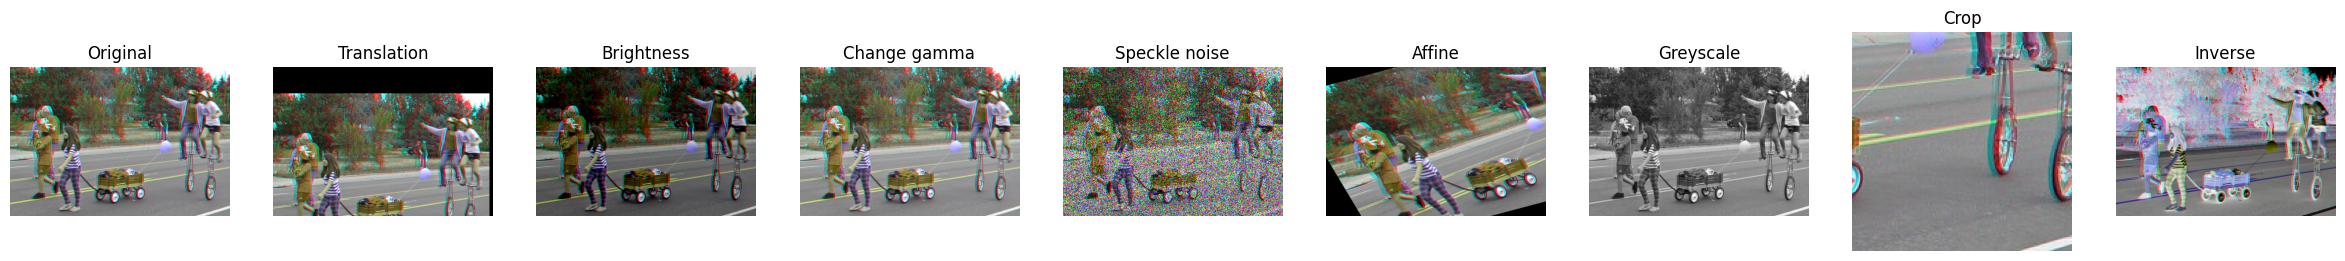

In [ ]:
augmentations = [
    rotation,
    zoom,
    flip_horizontal,
    flip_vertical,
    greyscale,
    inverse,
    blur,
    crop,
    affine,
    change_gamma,
    translation,
    elastic_transform,
    brightness,
    histogram_eq,
    salt_e_pepper,
    gaussian_blur,
    poisson_noise,
    speckle_noise,
    contrast,
]


augmentations_names = [
    "Rotation",
    "Zoom",
    "Horizontal flip",
    "Vertical flip",
    "Greyscale",
    "Inverse",
    "Blur",
    "Crop",
    "Affine",
    "Change gamma",
    "Translation",
    "elastic transform",
    "Brightness",
    "Histogram equalization",
    "Salt and pepper",
    "Gaussian blur",
    "Poisson noise",
    "Speckle noise",
    "Contrast",
]




def apply_augmentations(img, num_aug, centroid=None):
    ret_images = []
    ret_names = []

    ret_images.append(img)
    ret_names.append("Original")

    applied_augmentations = set()

    while len(ret_images) - 1 < num_aug:  # Exclude original image from count
        img_copy = img.copy()
        img_np = np.array(img_copy)

        n = random.randint(0, len(augmentations) - 1)
        aug_name = augmentations_names[n]

        # When applying an augmentation, we first check if it has already been applied
        # to ensure that each augmentation is applied only once per image.
        if aug_name not in applied_augmentations:
            applied_augmentations.add(aug_name)

            # Apply augmentation
            if aug_name == "Crop":
                img_aug_np = augmentations[n](img_np, center=centroid)
            else:
                img_aug_np = augmentations[n](img_np)


            # Convert NumPy array back to PIL image
            img_aug = Image.fromarray(img_aug_np)

            ret_images.append(img_aug)

            # we want to take track of the augmentations applied at each image
            ret_names.append(aug_name)

    return ret_images, ret_names

img = Image.open(get_random_imagenet_a_image(pathDatasetImagenetA))

aug, names = apply_augmentations(img, 8)

plt.figure(figsize=(30, 30))

for i in range(len(aug)):
    plt.subplot(1, len(aug), i+1)

    plt.imshow(aug[i])
    plt.title(names[i])
    plt.axis('off')

plt.show()

## **Our MEMO_PLUS version**

Our work has been focused on increasing the impact and quality of augmentations for the original MEMO pipeline. To achieve this goal, we decided to expand the MEMO's augmentations adding our segmentations. The main idea is to provide as input, to the model, the most informative section of each image. This approach aims to remove the undesired parts, for example useless objects in the background that can confuse the model.

To obtain the desired segmentations, we used [**Segment Anything from MetaAI**](https://segment-anything.com/).

To handle this segmentatations, we tried many approaches: blurring the background keeping only the subject not blurred, cropping the image keeping only the subject or cuttin out the subject.
These experiments have shown us that the best technique is to maintain the original size of the image, setting every pixel of the image, that is not contained in the subject's bounding box, to black. This approach generates two main advantages: firstly, keeping the original size of the image, we are preserving the proportion, secondly, since we are creating a bounding box, the edge is not influencing the model's decision.


<center>

| Blur      | BBox crop   | Cut out       | BBox crop on original image      |
|------------|---------------|------------|------------|
| <img src="https://raw.github.com/stefanoobonetto/DeepLearning_project/7246cb83a56e28b0865c623151b6328a880b4929/imagesReport/segmentation/blur.png" alt="Blur Image" width="200"> |  <img src="https://raw.github.com/stefanoobonetto/DeepLearning_project/7246cb83a56e28b0865c623151b6328a880b4929/imagesReport/segmentation/crop.jpeg" alt="Crop Image" width="100">  | <img src="https://raw.github.com/stefanoobonetto/DeepLearning_project/7246cb83a56e28b0865c623151b6328a880b4929/imagesReport/segmentation/ritagliata.jpeg" alt="Ritagliata Image" width="200"> | <img src="https://raw.github.com/stefanoobonetto/DeepLearning_project/7246cb83a56e28b0865c623151b6328a880b4929/imagesReport/segmentation/correct.jpeg" alt="Correct Image" width="200">|


</center>

In our initial solution, from each input image, we selected 8 augmentations along with a series of segmentations. For these segmentations, we chose only the first 10 largest ones based on area.
However, we realized that, given our dataset, the largest regions often did not contain relevant information, causing a loss in model performances.

Therefore, we integrated a Grad-CAM component into the pipeline. We used this tool to select the best segmentations, this time considering where the information is located in the image instead of selecting the largest ones. From the Grad-CAM algorithm, we are able to extract a point in the image where the heatmap has a maximum value. Using this point, we can select those segmentations related to this point of interest, where theoretically the class' subject is contained.

<br>

<center>
<img src="https://raw.github.com/stefanoobonetto/DeepLearning_project/cf7f29aa4e98dcf3f1880edf1ad506bddbb74f27/imagesReport/MEMO_PLUS_no_sfondo.png" alt="Elbow Method" width="1500" />
</center>

<p align="center"><i>Our MEMO_PLUS pipeline: an initial prediction on the class is inferred passing the original image to the ViTB-16 model, this initial prediction is used by GradCAM to produce the heatmap. In the meantime SegmentAnything extract the 10 bigger segmentations (upper to a minimum threshold). Then select the nearest one (or ones) from the highest point of the heatmap given by GradCAM. Then this (or these) segmentation are stacked with the inital 8 augmentations + the original image (same as Vanilla MEMO). </i></p>

<br>
<hr>

### **Our segmentation example**

Generally speaking, our approach works perfectly if the segmentation matches the given point of interest (Grad-CAM), and if the point of interest is correct. Here below we presented two cases: in the first image (left) our algorithm was able to clearly identify the subject in the image, while in the second image (right), given the challenging scenario contained in the picture, the segmentation selected does not contain the subject. This example explains the advantages and disadvantages of our solution.


<div align="center">

| **Correct segmentation**      | **Wrong segmentation**   |
|------------|---------------|
|<img src="https://raw.github.com/stefanoobonetto/DeepLearning_project/3802e1c53ea90b7335a77f40cef9d284a1128601/imagesReport/correctSegmentation.png" alt="Elbow Method" width="250" />| <img src="https://raw.github.com/stefanoobonetto/DeepLearning_project/3802e1c53ea90b7335a77f40cef9d284a1128601/imagesReport/wrongSegmentation.png" alt="Elbow Method" width="402" />|

</div>




In [ ]:
def segment_image(aug, mask_generator, centroid):
    ret_images = []
    original_image = aug[0]
    ret_images.append(original_image)

    # Convert and resize image
    image_np = np.array(original_image)
    masks = mask_generator.generate(image_np)

    min_mask_size = 500  # Adjustable minimum mask size (threshold)

    # Filter out small masks and calculate areas of valid masks
    filtered_masks = [(i, mask, np.sum(mask["segmentation"])) for i, mask in enumerate(masks) if np.sum(mask["segmentation"]) >= min_mask_size]

    # Sort masks by area in descending order
    filtered_masks.sort(key=lambda x: x[2], reverse=True)

    # Keep only the top 10 masks
    top_masks = filtered_masks[:10]

    black_background_np = np.zeros_like(image_np)

    # Draw centroid on the resized image
    centroid_x, centroid_y = centroid
    centroid_resized = (int(centroid_x * image_np.shape[1] / 224), int(centroid_y * image_np.shape[0] / 224))


    mask_found = False
    closest_mask = None
    min_distance = float('inf')
    found_masks = []

    # Process each mask
    for i, (original_index, mask, mask_size) in enumerate(top_masks):
        mask_np = mask["segmentation"]

        # Check if the centroid is within the mask
        if mask_np[centroid_resized[1], centroid_resized[0]]:
            mask_found = True
            found_masks.append(mask_np)

        # Calculate the centroid of the mask
        mask_indices = np.argwhere(mask_np)
        if mask_indices.size > 0:
            mask_centroid = mask_indices.mean(axis=0)
            distance = np.linalg.norm(np.array(centroid_resized) - mask_centroid)
            if distance < min_distance:
                min_distance = distance
                closest_mask = (original_index, mask_np)

    # If no mask contains the centroid, select the closest and largest mask
    if not mask_found and closest_mask:
        _, mask_np = closest_mask
        found_masks.append(mask_np)

    for i, elem in enumerate(found_masks):
        mask_np = np.array(elem)

        # Find the bounding rectangle for the mask
        mask_indices = np.argwhere(mask_np)
        if mask_indices.size > 0:
            y_min, x_min = mask_indices.min(axis=0)
            y_max, x_max = mask_indices.max(axis=0)

            # Create an empty black background
            black_background_np = np.zeros_like(image_np)

            # Copy the content of the bounding box from the original image
            black_background_np[y_min:y_max+1, x_min:x_max+1] = image_np[y_min:y_max+1, x_min:x_max+1]

            # Convert to PIL Image and append to ret_images
            ret_images.append(Image.fromarray(black_background_np))

    return ret_images

## **Experiments and results**

For all experiments we'll use AdamW as optimizer with $\eta = 2.5\cdot 10^{-4}$ that will remain constant across all experiments to maintain a standardized benchmark.

In [ ]:
lr = 0.00025
weight_decay = 1e-2

The `test_model` function evaluates the model's performance on a single input image. It preprocesses the image using the predefined transformation, passes it through the model in evaluation mode, and computes the correctness of the model's prediction ($1$ if guessed, $0$ if not) along with its confidence level.

In [ ]:
def test_model(image, target, model):
    model.eval()
    inputs = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(inputs)
        outputs = outputs[:, indices_in_1k]

        _, predicted = outputs.max(1)
        confidence = nn.functional.softmax(outputs, dim=1).squeeze()[predicted].item()
    correctness = 1 if predicted.item() == target else 0
    return correctness, confidence

The `tune_model` function is used to apply MEMO and MEMO_PLUS. It first generates and transforms augmented versions of the input image. If required (case of MEMO_PLUS), segmentations are added to these augmentations. The model then performs inference on the augmented stack, calculates the mean output, computes the loss (marginal entropy), and updates the model parameters through backpropagation and optimization. The function returns the augmented images and their names used for further analysis.

In [ ]:
def tune_model(image, model, mask_generator, optimizer, cost_function, num_aug, flag_memo_plus = False, centroid= None):

    model.eval()
    aug, names = apply_augmentations(image, num_aug, centroid) # num_aug +1 images

    # This will be used in our version to add to the augmentations' stack the choosen segmentation
    if flag_memo_plus:
        segmentation = segment_image(aug, mask_generator, centroid)
        for elem in segmentation:
            aug.append(elem)

    # Apply transform to all augmentations (resize, etc...)
    transformed_aug = transform_images(aug)

    input = torch.stack(transformed_aug).to(device)
    optimizer.zero_grad()

    # Inference
    output = model(input)

    output = torch.mean(output, dim = 0)
    output = output.unsqueeze(0)
    output = output[:, indices_in_1k]
    loss,_ = cost_function(output)

    loss.backward()
    optimizer.step()

    return aug, names

The `summation` function is used to calculate the accuracy.

In [ ]:
def summation(lst):             # this is used then to compute accuracy
    ret = 0
    for elem in lst:
        ret += elem[0]
    return ret

### **Experiment 1: ResNet50 Vs VitB-16**
In this section, we present a detailed comparative analysis of two prominent deep learning architectures—ResNet50 and Vision Transformer (ViT-B/16)—for the task of image classification on the ImagenetA dataset. The primary objective of these experiments is to evaluate the performance in handling the complexities and variations present in this challenging dataset to determine which model, between ResNet50 and ViT-B/16, performs better overall. This will guide the selection of the best-performing model as the foundation for subsequent experiments.

#### **Experiment 1.1: Vanilla ResNet50**

For the first experiment, we evaluated the performances of a Vanilla ResNet50 on the ImagenetA dataset, to understand which was the starting point in term of accuracy. As previously indicated, this ResNet50 has been already trained on Imagenet-1K. Here's a concise summary of the process:

  1. **Initialization**: we initialized the model and saved its initial weights.
  2. **Data Processing**: for each image in the dataset:
     - Evaluated the model's performance and recorded the accuracy.

In [ ]:
model = ModelResNet().to(device)

# Load dataset
test_data = get_WholeDataset(batch_size=1, img_root=pathDatasetImagenetA)

correct_before_memo = []
accuracy_classes_RN = {}

for i in range(200):
    accuracy_classes_RN[f"{i}_before_MEMO"] = {"prediction":[], "augmentation":[]}        # Just to plot results

# Process test data
pbar = tqdm.tqdm(range(len(test_data)))

for i in pbar:

    # Load an image and its target
    image, target = test_data[i]
    correct_before_memo.append(test_model(image=image, target=target, model=model))
    accuracy_before_memo = round((summation(correct_before_memo)/len(correct_before_memo))*100, 2)
    accuracy_classes_RN[f"{target}_before_MEMO"]["prediction"].append(correct_before_memo[i])
    pbar.set_description(f'Accuracy: {accuracy_before_memo:.2f}%')

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:02<00:00, 50.5MB/s]
Accuracy: 12.69%: 100%|██████████| 7500/7500 [02:14<00:00, 55.93it/s]


##### **1.1 Results**
The graph below illustrates the class-wise accuracy of the ResNet50 model on the ImagenetA dataset. Each point on the x-axis represents a distinct class, numbered from 0 to 200, while the y-axis indicates the accuracy percentage for each class.

In [ ]:
# # Prepare data for plotting
# class_labels_RN = list(accuracy_classes_RN.keys())
# xticks_num = list(i for i in range(200))
# accuracies_RN = [np.mean(accuracy_classes_RN[label]["prediction"])*100 for label in class_labels_RN]

# # Plotting
# plt.figure(figsize=(12, 6))
# plt.plot(xticks_num, accuracies_RN, marker='o', linestyle='-', color='b', label="ResNET-50")
# plt.xticks(rotation=90)
# plt.xlabel('Class Labels')
# plt.ylabel('Mean Accuracy (%)')
# plt.title('Class-wise Accuracy Before MEMO')
# plt.legend()

# plt.tight_layout()
# plt.savefig('ResNET50_accuracy[VANILLA].png')
# plt.show()

<center>

<img src="https://raw.github.com/stefanoobonetto/DeepLearning_project/2f1ca57bfd93aaa0d8fcca1df90890f05a516b12/imagesReport/ResNET50_accuracy%5BVANILLA%5D.png" alt="MEMO" width="800"/>

</center>



The model's performance varies significantly across different classes. Some classes exhibit high accuracy, with peaks reaching up to 50%, whereas others show much lower accuracy, sometimes dropping below 10%. Generally speaking, we obtained better results compared to the reference paper, considering that **their accuracy level was of 0%**, while we were able to **predict correctly 951 out of 7500 images**, with an **accuracy of around 12,6%** (depending on the run).

Based on our assumptions, this is due to our weights inizialization considering that we're using the same model as the original paper implementation.  

#### **Experiment 1.2: Vanilla VitB-16**

In this section, we repeated the same experiment as before, this time using a pretrained Visual Transformer (VitB-16) to understand which architecture, between the ResNet and the Transformer, worked better as a foundation for the next experiments. Here's a concise summary of the process:

  1. **Initialization**: we initialized the model and saved its initial weights.
  2. **Data Processing**: for each image in the dataset:
     - Evaluated the model's performance and recorded the accuracy.

<br>

In [ ]:
model = ModelVitb16().to(device)

# Load dataset
test_data = get_WholeDataset(batch_size=1, img_root=pathDatasetImagenetA)

correct_before_memo = []
accuracy_classes_ViT = {}

for i in range(200):
    accuracy_classes_ViT[f"{i}_before_MEMO"] = {"prediction":[]}  # Just to plot results

# Process test data
pbar = tqdm.tqdm(range(len(test_data)))  # Adjust the range as necessary
for i in pbar:

    # Load an image and its target
    image, target = test_data[i]

    # Test the model before applying MEMO
    correct_before_memo.append(test_model(image=image, target=target, model=model))
    accuracy_before_memo = round((summation(correct_before_memo)/len(correct_before_memo))*100, 2)

    accuracy_classes_ViT[f"{target}_before_MEMO"]["prediction"].append(correct_before_memo[i])
    pbar.set_description(f'Accuracy: {accuracy_before_memo:.2f}%')

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:04<00:00, 79.2MB/s]
Accuracy: 17.40%: 100%|██████████| 7500/7500 [02:35<00:00, 48.34it/s]


##### **1.2 Results**

The graph below illustrates the class-wise accuracy of the VitB-16 model on the ImagenetA dataset. Each point on the x-axis represents a distinct class, numbered from 0 to 200, while the y-axis indicates the accuracy percentage for each class.

In [ ]:
# # Prepare data for plotting
# class_labels_Vit = list(accuracy_classes_ViT.keys())
# xticks_num = list(i for i in range(200))
# accuracies_Vit = [np.mean(accuracy_classes_ViT[label]["prediction"])*100 for label in class_labels_Vit]

# # Plotting
# plt.figure(figsize=(12, 6))
# plt.plot(xticks_num, accuracies_Vit, marker='o', linestyle='-', color='g',label="VitB-16")
# plt.xticks(rotation=90)
# plt.xlabel('Class Labels')
# plt.ylabel('Mean Accuracy (%)')
# plt.title('Class-wise Accuracy ViTB-16')

# plt.legend()

# plt.tight_layout()
# plt.savefig('ViT_accuracy[VANILLA].png')
# plt.show()

<center>

<img src="https://raw.github.com/stefanoobonetto/DeepLearning_project/17c9c0949c1b95d3085bc330b072b73ca7939b56/imagesReport/ViT_accuracy%5BVANILLA%5D(1).png" alt="MEMO" width="800"/>

</center>



As it is possible to observe from the graph, the virgin VitB-16 performances  varies significatly from class to class. **The model was able to correctly classify 1305 images out of the 7500, with an accuracy 17,4%**.    

#### **Conclusions and comparison**

This comparative analysis indicates that the Vision Transformer (ViT-B/16) model significantly outperforms the ResNet50 model in classifying images from the ImagenetA dataset. The ViT-B/16 model's ability to capture long-range dependencies and global context appears to provide a substantial advantage over the traditional convolutional approach of ResNet50. These findings suggest that ViT-B/16 is the more robust and effective model for this dataset, making it a preferable choice for further experimentation and model development.

In [ ]:
# # Plotting
# plt.figure(figsize=(12, 6))
# plt.plot(xticks_num, accuracies_Vit, marker='o', linestyle='-', color='g', label="ViTB-16")
# plt.plot(xticks_num, accuracies_RN, marker='o', linestyle='-', color='b',label="ResNET-50")
# plt.xticks(rotation=90)
# plt.xlabel('Class Labels')
# plt.ylabel('Mean Accuracy (%)')
# plt.title('Class-wise Accuracy Before MEMO')

# plt.legend()

# plt.tight_layout()
# plt.savefig('comparison_accuracy[VANILLA].png')
# plt.show()


<center>

<img src="https://raw.github.com/stefanoobonetto/DeepLearning_project/2f1ca57bfd93aaa0d8fcca1df90890f05a516b12/imagesReport/comparison_accuracy%5BVANILLA%5D.png" alt="MEMO" width="800"/>

</center>



![]()

### **Experiment 2: Implementing MEMO**

In this experiment, we evaluated the performance of ViTB-16 model on a dataset before and after applying MEMO implementation. Here's a concise summary of the process:

  1. **Initialization**: we initialized the model and saved its initial weights.
  2. **Data Processing**: for each image in the dataset:
     - Reset the model to initial weights.
     - Evaluated the model's performance before applying MEMO and recorded the accuracy.
     - Compute the point of interest using GradCAM (used to compute center of crop augmentation).
     - Applied MEMO_PLUS with 8 augmentations + the original image.
     - Evaluated the model's performance after applying MEMO and recorded the accuracy.
     - To evaluate the improvements, we visually compare the heatmaps generated by GradCAM after the complete inference of our MEMO model.

In [ ]:
# Load dataset
test_data = get_WholeDataset(batch_size=1, img_root=pathDatasetImagenetA)

# Number of augmentations
num_aug = 8

model = ModelVitb16().to(device)
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
target_layers = [model.vitb.encoder.layers[-1].ln_1]

initial_weights_path = os.path.join(current_dir, "weights/weights_used.pth")
!mkdir -p weights
torch.save(model.state_dict(), initial_weights_path)

# Lists to store results
correct_before_memo = []
correct_after_memo = []
accuracy_classes = {}

for i in range(200):
    accuracy_classes[f"{i}_before_MEMO"] = {"prediction":[]}
    accuracy_classes[f"{i}_after_MEMO"] = {"prediction":[]}


# Process test data
pbar = tqdm.tqdm(range(len(test_data)))  # Adjust the range as necessary
for i in pbar:

    # Reset model to initial weights before each iteration
    model.load_state_dict(torch.load(initial_weights_path))
    model.eval()

    # Load an image and its target
    image, target = test_data[i]

    # Test the model before applying MEMO
    correct_before_memo.append(test_model(image=image, target=target, model=model))

    gradcam_initial, centroid, regions = create_gradcam(np.float32(image) / 255, model, target_layers)

    # Tune the model using MEMO
    augmentation, name_aug = tune_model(image=image, model=model, mask_generator=None, optimizer=optimizer, cost_function=marginal_entropy, num_aug=num_aug, flag_memo_plus=False, centroid=centroid)

    # Test the model after applying MEMO
    correct_after_memo.append(test_model(image=image, target=target, model=model))

    gradcam_memo, centroid, regions= create_gradcam(np.float32(image) / 255, model, target_layers)


    accuracy_before_memo = (summation(correct_before_memo)/len(correct_before_memo))*100
    accuracy_after_memo = (summation(correct_after_memo)/len(correct_after_memo))*100

    accuracy_classes[f"{target}_before_MEMO"]["prediction"].append(correct_before_memo[i])
    accuracy_classes[f"{target}_after_MEMO"]["prediction"].append(correct_after_memo[i])

    pbar.set_description(f'Before MEMO: {accuracy_before_memo:.2f}%  after MEMO: {accuracy_after_memo:.2f}%')

Before MEMO: 17.02%  after MEMO: 23.40%:   1%|          | 47/7500 [00:35<1:33:26,  1.33it/s]


KeyboardInterrupt: 

#### **2 Results**

Using MEMO, the model was able to **correctly classify 1417 images out of 7500**, with a general **accuracy of 18,89%**, compared to the results obtained with the **virgin VitB-16 of 17,4%**.

The implementation of MEMO has slightly improved the model's accuracy across most classes. For some classes, the orange points (after MEMO) are higher than the blue points (before MEMO), indicating an enhancement in the model's performance. On the other side, MEMO doesn't always perform better compared to the vanilla implementation, considering the uncertainty introduced by augmenting images that are challenging to interpretate.

The graph below illustrates the comparison of model accuracy between the implementation of the Minimum Entropy Maximization Objective (MEMO) on the Vision Transformer (ViT-B/16) and the vanilla ViT-B/16 for classifying images from the ImagenetA dataset. The x-axis represents different classes (ranging from 0 to 200, divided in 4 ranges for visualization purposes), while the y-axis indicates the accuracy percentage. The blue line represents the model's accuracy before applying MEMO, and the orange line represents the accuracy after applying MEMO.

<center>

<img src="https://raw.github.com/stefanoobonetto/DeepLearning_project/88876d7d5a0800a29f9caee46d7657204e8cb18d/imagesReport/vanillaVsMEMO.jpg" alt="MEMO" width="800"/>

</center>

### **Experiment 3: MEMO_PLUS, our improvements**

In this experiment we want to evaluate performances of our MEMO_PLUS implementation with the new segmentation.

For our version we're in need of installing an application that will be useful in the segmentation phase: SegmentAnything is a tool that enables us to extract semantic segmentations from our original images.

We chose this application, developed by MetaAI, because it is highly reliable and widely recognized for its effectiveness in solving segmentation tasks.

In [ ]:
!FILE="weights/sam_vit_b_01ec64.pth"
!if [ -f $FILE ]; then
!   echo "File $FILE already exists."
!else
!   mkdir -p weights
!   wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth -P weights

! pip install git+https://github.com/facebookresearch/segment-anything.git

/bin/bash: -c: line 2: syntax error: unexpected end of file
File  already exists.
/bin/bash: -c: line 1: syntax error near unexpected token `else'
/bin/bash: -c: line 1: `else'
--2024-07-18 16:44:01--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 108.157.254.121, 108.157.254.102, 108.157.254.124, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|108.157.254.121|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 375042383 (358M) [binary/octet-stream]
Saving to: ‘weights/sam_vit_b_01ec64.pth’

sam_vit_b_01ec64.pt 100%[===================>] 357.67M   185MB/s    in 1.9s    

2024-07-18 16:44:03 (185 MB/s) - ‘weights/sam_vit_b_01ec64.pth’ saved [375042383/375042383]

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-n7c2jlr1
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything

In this experiment, we evaluated the performance of our ViT model on a dataset before and after applying our MEMO_PLUS implementation. Here's a concise summary of the process:

  1. **Initialization**: we initialized the model and saved its initial weights.
  2. **Segmentation Model**: loaded a segmentation model with a predefined checkpoint.
  3. **Data Processing**: for each image in the dataset:
     - Reset the model to initial weights.
     - Evaluated the model's performance before applying MEMO_PLUS and recorded the accuracy.
     - Compute the point of interest using GradCAM  
     - Applied MEMO_PLUS with 8 augmentations + the original image + segmentation(s).
     - Evaluated the model's performance after applying MEMO_PLUS and recorded the accuracy.
     - To evaluate the improvements, we visually compare the heatmaps generated by GradCAM after the complete inference of our MEMO_PLUS model.

In [ ]:
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry

# Define paths and directories
checkpoint_path = os.path.join(current_dir, "weights/sam_vit_b_01ec64.pth")

# Load dataset
test_data = get_WholeDataset(batch_size=1, img_root=pathDatasetImagenetA)

# Number of augmentations
num_aug = 8

model = ModelVitb16().to(device)
target_layers = [model.vitb.encoder.layers[-1].ln_1]
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

initial_weights_path = os.path.join(current_dir, "weights/weights_model_in_use.pth")
torch.save(model.state_dict(), initial_weights_path)

# Load segmentation model
model_type = "vit_b"
segmentation_model = sam_model_registry[model_type](checkpoint=checkpoint_path).to(device)
mask_generator = SamAutomaticMaskGenerator(segmentation_model)

# Lists to store results
correct_before_memo = []
correct_after_memo_plus = []
accuracy_classes = {}

for i in range(200):
    accuracy_classes[f"{i}_before_MEMO"] = {"prediction":[]}
    accuracy_classes[f"{i}_after_MEMO_PLUS"] = {"prediction":[]}

# Process test data
pbar = tqdm.tqdm(range(len(test_data)))  # Adjust the range as necessary
for i in pbar:
    # Reset model to initial weights before each iteration
    model.load_state_dict(torch.load(initial_weights_path))
    model.eval()


    # Load an image and its target
    image, target = test_data[i]

    # Test the model before applying MEMO
    correct_before_memo.append(test_model(image=image, target=target, model=model))

    gradcam_initial, centroid, regions = create_gradcam(np.float32(image) / 255, model, target_layers)

    # Tune the model using MEMO
    segmentation, name_aug_plus = tune_model(image=image, model=model, mask_generator=mask_generator, optimizer=optimizer, cost_function=marginal_entropy, num_aug=num_aug, flag_memo_plus=True, centroid=centroid)

    # Test the model after applying MEMO
    correct_after_memo_plus.append(test_model(image=image, target=target, model=model))

    gradcam_memo_plus,_,_ = create_gradcam(np.float32(image) / 255, model, target_layers)

    accuracy_before_memo = (summation(correct_before_memo)/len(correct_before_memo))*100
    accuracy_after_memo_plus = (summation(correct_after_memo_plus)/len(correct_after_memo_plus))*100

    accuracy_classes[f"{target}_before_MEMO"]["prediction"].append(correct_before_memo[i])
    accuracy_classes[f"{target}_after_MEMO_PLUS"]["prediction"].append(correct_after_memo_plus[i])


    pbar.set_description(f'Before MEMO: {accuracy_before_memo:.2f}% after MEMO_PLUS: {accuracy_after_memo_plus:.2f}%')


Before MEMO: 13.16% after MEMO_PLUS: 15.79%:   1%|          | 38/7500 [03:31<11:30:57,  5.56s/it]


KeyboardInterrupt: 

#### **3 Results**

Using our MEMO_PLUS, the model was able to **correctly classify 1433 images out of 7500**, with a general **accuracy of 19,11%**, compared to the results obtained with the **virgin VitB-16 of 17,4%** and with **MEMO of 18,89%**.

Our MEMO_PLUS has slightly improved the model's accuracy across most classes. For some classes, the solution we developed has shown the capability to predict more accuratly the images, resulting in a promising approach for possible future developments. On the other side, this approach requires large computational resources, increasing the execution time (it takes ≈ 5 seconds per image, ≈ 4.8 seconds using AWS).  

The graph below illustrates the comparison of model accuracy between our version of the Minimum Entropy Maximization Objective (MEMO) on the Vision Transformer (ViT-B/16) and the vanilla ViT-B/16 for classifying images from the ImagenetA dataset. The x-axis represents different classes (ranging from 0 to 200, divided in 4 ranges for visualization purposes), while the y-axis indicates the accuracy percentage. The blue line represents the model's accuracy before applying MEMO_PLUS, and the orange line represents the accuracy after applying our version of MEMO_PLUS.

<center>

<img src="https://raw.github.com/stefanoobonetto/DeepLearning_project/835417b3958387cd92dcf207e2869f8f4c44949a/imagesReport/vanillaVsMEMO_PLUS.jpg" alt="MEMO" width="800"/>

</center>



## **Conclusions**

In this project, we addressed the challenge of domain shift, which affects the performance of deep neural networks on datasets like ImageNet-A. We focused on enhancing the Marginal Entropy Minimization with One test point (MEMO) method, a Test Time Adaptation (TTA) technique, to improve robustness and accuracy on diverse and unseen datasets.

Our key improvement involved augmentations within the MEMO pipeline by introducing segmentations using Segment Anything from MetaAI. By isolating the most informative sections of images and setting non-subject pixels to black while maintaining the original size, we achieved cleaner and higher-quality augmentations. This approach preserved image proportions and prevented edge effects from influencing model decisions.

To further refine our method, we integrated Grad-CAM, allowing us to identify the most relevant parts of images based on maximum heatmap values. This enabled us to select more informative segmentations, enhancing model performance.

Our refined MEMO method demonstrates significant improvements in handling domain shifts, ensuring deep neural networks can adapt to new and diverse datasets with greater robustness and accuracy. These advancements represent a crucial step towards more resilient and adaptable AI systems.


**Here below are listed the results obtained during our experiments:**

<center>

|   | Virgin ViTB-16   | MEMO   | Our version |
|---|------------|------------|------------|
| Top1 Accuracy | 17,40% | 18,89%| 19,11%|
| Number of correctly classified images | 1305| 1417| 1433|
| Execution Time (≈) | 3 minutes | 76 minutes | 614 minutes|

</center>


#### **Possible future improvements**

As previously noted, the main weakness of our solution is the significant amount of computational resources and time required for the algorithm to function. Therefore, a possible future development would be to use more efficient segmentation or augmentation techniques. Additionally, we believe that using a model like DINO could improve performance.

# **The team**

<center>

| Simone Roman      | Stefano Bonetto   | Alberto Dian  |
|------------|---------------|------------|
|<img src="https://raw.github.com/stefanoobonetto/DeepLearning_project/15f43476ebdd38b6297f6a88894b093d79ac6625/team/foto%20simo.jpg" alt="Elbow Method" width="200" />| <img src="https://raw.github.com/stefanoobonetto/DeepLearning_project/15f43476ebdd38b6297f6a88894b093d79ac6625/team/bonnie.jpeg" alt="Elbow Method" width="200" />| <img src="https://raw.github.com/stefanoobonetto/DeepLearning_project/6952714b5c0882a48ad3eaa28c4586cdece2ae91/team/baibu.jpg" alt="Elbow Method" width="200" />|
|**simone.roman@studenti.unitn.it**|**stefano.bonetto@studenti.unitn.it**|**alberto.dian@studenti.unitn.it**|
|247181|247179|247376|
|Artificial Intelligence Systems|Artificial Intelligence Systems|EIT Autonomous Systems|

</center>
